In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset

In [2]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "./cat-and-dog"
walk_through_dir(image_path)

There are 2 directories and 0 images in './cat-and-dog'.
There are 2 directories and 0 images in './cat-and-dog/test_set'.
There are 0 directories and 1012 images in './cat-and-dog/test_set/cats'.
There are 0 directories and 1013 images in './cat-and-dog/test_set/dogs'.
There are 2 directories and 0 images in './cat-and-dog/training_set'.
There are 0 directories and 4001 images in './cat-and-dog/training_set/cats'.
There are 0 directories and 4006 images in './cat-and-dog/training_set/dogs'.


In [3]:
train_dir = "./cat-and-dog/training_set/"
test_dir = "./cat-and-dog/test_set"
train_dir, test_dir

('./cat-and-dog/training_set/', './cat-and-dog/test_set')

In [4]:
from torchvision import datasets, transforms

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])


# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: ./cat-and-dog/training_set/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: ./cat-and-dog/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [5]:
# Get class names as a list
class_names = train_data_augmented.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data_augmented.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data_augmented), len(test_data_augmented))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
The lengths of the training and test sets:  8005 2023


### Dataloader

In pytorch, the `DataLoader` class is used to load data from the dataset. It provides an iterable over the dataset. The `DataLoader` class provides many helpful features such as batching, shuffling, and parallel data loading.

In [6]:
from torch.utils.data import DataLoader

NUM_WORKERS = 4
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

### Model Definition

In [7]:
# # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32), # Batch Normalization
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2)) 
        self.conv_layer_4 = nn.Sequential(
          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2)) 
        self.conv_layer_5 = nn.Sequential(
          nn.Conv2d(256, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.conv_layer_6 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor): # x : [batch_size, 3, 224, 224]
        x = self.conv_layer_1(x) # x : [batch_size, 32, 112, 112]
        x = self.conv_layer_2(x) # x : [batch_size, 64, 56, 56]
        x = self.conv_layer_3(x) # x : [batch_size, 128, 28, 28]
        x = self.conv_layer_4(x) # x : [batch_size, 256, 14, 14]
        x = self.conv_layer_5(x) # x : [batch_size, 512, 7, 7]
        x = self.conv_layer_6(x) # x : [batch_size, 512, 3, 3]
        x = self.classifier(x) # x : [batch_size, 512*3*3] -> [batch_size, 2]
        return x

# Instantiate an object.
model = ImageClassifier()
# Compile the model
model = torch.compile(model)
model = model.to(device)

In [8]:
# number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,940,610 trainable parameters


3.94M parameters is a big number. But is not huge when compared to models like ResNet-50 which has 25.6M parameters.

### Training Step

In [9]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### Evaluation Step

In [10]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Training Loop

In [11]:
from rich.progress import Progress

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    with Progress() as progress:
        task = progress.add_task("[red]Training...", total=epochs)
        for epoch in range(epochs):
            train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
            test_loss, test_acc = test_step(model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn)
            
            # 4. Print out what's happening
            progress.console.print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

            # 5. Update results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
            progress.advance(task)

    # 6. Return the filled results at the end of the epochs
    return results

In [12]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Training... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━  93% 0:00:11

Epoch: 15 | train_loss: 0.1887 | train_acc: 0.9176 | test_loss: 0.1980 | test_acc: 0.9199

Total training time: 198.302 seconds


In [13]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

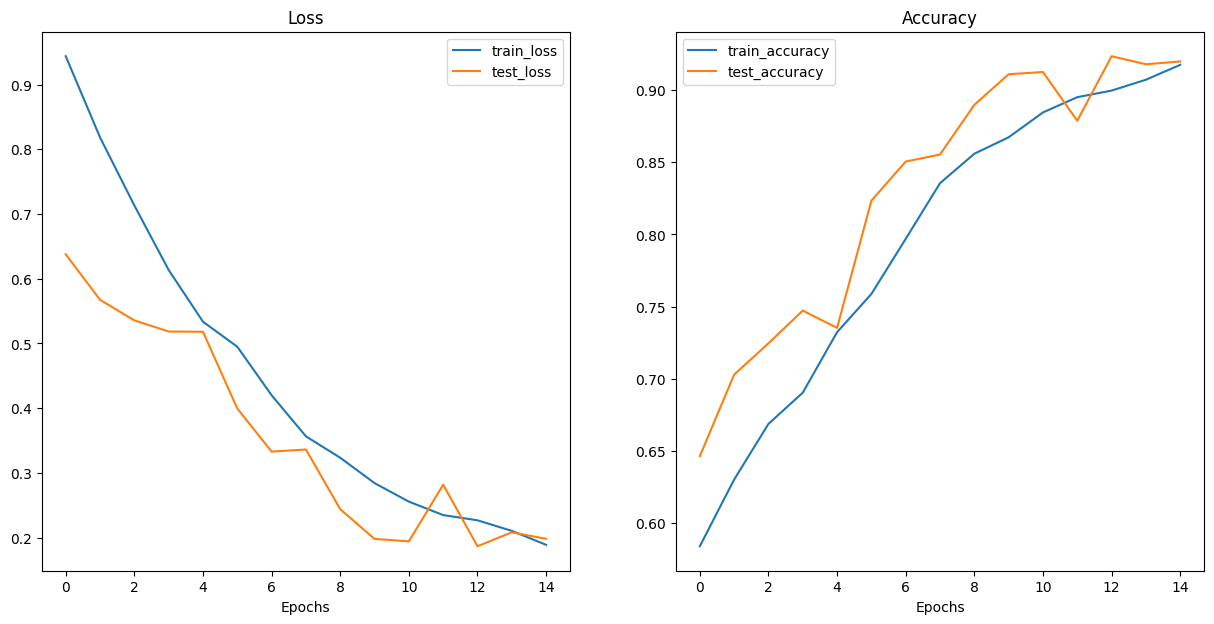

In [14]:
plot_loss_curves(model_results)

### Save the model

In [15]:
## Save the model
model_save_name = 'cat_dog_classifier.pt'
path = f"./checkpoints/{model_save_name}"
os.makedirs(os.path.dirname(path), exist_ok=True)
torch.save(model.state_dict(), path) 
# Now you can load the trained model later by using model.load_state_dict(torch.load(path))
# and no need to retrain the model again.

# Also it is a good practice to save the optimizer state as well.
optimizer_save_name = 'cat_dog_classifier_optimizer.pt'
path = f"./checkpoints/{optimizer_save_name}"
os.makedirs(os.path.dirname(path), exist_ok=True)
torch.save(optimizer.state_dict(), path)